In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text
import datetime as dt

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
#Finding my columns with the inspector
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

last_12_months = session.query(measurement.date, measurement.prcp)\
                .filter((measurement.date < '2017-08-23')&(measurement.date >=(dt.date(2017,8,23)-dt.timedelta(days=365)))).\
                order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(last_12_months)
# Sort the dataframe by date

sorted_df = df.sort_values(['date'])
sorted_df
# Use Pandas Plotting with Matplotlib to plot the data

#chart = sorted_df.plot(kind='bar')
#x=np.arange(1,len(df['date'])+1) # I had a hard time
#chart = plt.bar(x,df['prcp'])
#chart.set_xticks([])
#plt.title('One Year precipitation metrics in Inches')
#plt.xlabel('Date')
#plt.ylabel('Inches')
#plt.show()

date  prcp
0     2016-08-23  0.00
1     2016-08-23  0.15
2     2016-08-23  0.05
3     2016-08-23   NaN
4     2016-08-23  0.02
...          ...   ...
2219  2017-08-21  0.00
2222  2017-08-21  0.56
2224  2017-08-22  0.00
2223  2017-08-22  0.00
2225  2017-08-22  0.50

[2226 rows x 2 columns]

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = df.describe()
stats

prcp
count  2017.000000
mean      0.177367
std       0.461568
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

# Exploratory Station Analysis

In [14]:
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset
count = session.query(func.count(station.station)).all()
count

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station)\
            .order_by(func.count(measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#I wasn't able to query all this in one line
temps = []
low = session.query(measurement.tobs).filter(measurement.station=='USC00519281').order_by(measurement.tobs).first()
high = session.query(measurement.tobs).filter(measurement.station=='USC00519281').order_by(measurement.tobs.desc()).first()
avg = session.query(func.avg(measurement.tobs)).filter(measurement.station=='USC00519281').all()
temps.append(low)
temps.append(high)
temps.append(avg)
temps

[(54.0,), (85.0,), [(71.66378066378067,)]]

Text(0, 0.5, 'Frequency')

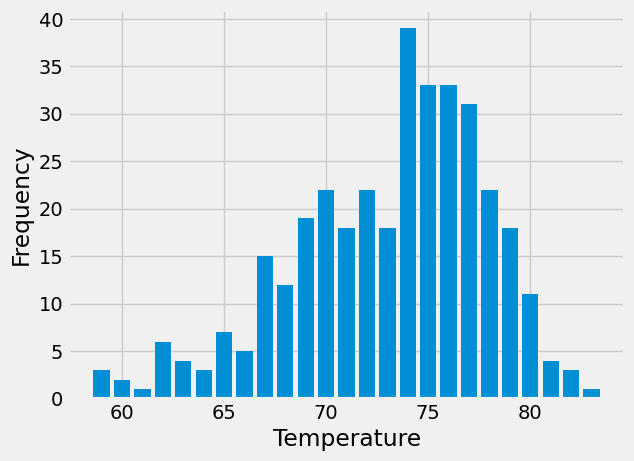

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# The below query was ran at first in order to query the last 12 months using session.query

last_12_months = session.query(measurement.tobs,func.count(measurement.tobs))\
                .filter((measurement.date < '2017-08-23')&(measurement.date >=(dt.date(2017,8,23)-dt.timedelta(days=365))))\
                .group_by(measurement.tobs).filter(measurement.station=='USC00519281').all()

#I continued the query using pandas.
query = text('SELECT measurement.tobs, count(measurement.tobs) from measurement WHERE measurement.date<"2017-08-23" and measurement.date >="2016-08-23" and measurement.station = "USC00519281" GROUP BY measurement.tobs')
with engine.connect() as cxn:
    results = cxn.execute(query)
    df = pd.read_sql(query,cxn)
x_axis = df['tobs']
y_axis = df['count(measurement.tobs)']

plt.bar(x_axis,y_axis)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

In [18]:
# Close Session
session.close()